# HDA - Project 3: TASK A
## Rows labelled with category 0 has been dropped
### In this context, first we dropped the rows and then missing values are interpolated using splines
Importing all modules that we need for our elaboration

In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import itertools

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    
    from keras import regularizers
    from keras.layers import Conv1D, Conv2D, BatchNormalization, Dropout, LeakyReLU, Flatten, Activation, Dense, MaxPooling1D, MaxPooling2D
    from keras.models import Model, Sequential
    from keras.optimizers import Adam
    import keras.backend as K
    
K.set_image_data_format('channels_last')

%matplotlib inline

Using TensorFlow backend.


## Preprocessing Section
Importing data sessions for subject 1

In [2]:
x1 = scipy.io.loadmat("prep/A_nonzero/S1-ADL1", mdict={'filled_features':'features', 'labels':'labels'})
x2 = scipy.io.loadmat("prep/A_nonzero/S1-ADL2", mdict={'filled_features':'features', 'labels':'labels'})
x3 = scipy.io.loadmat("prep/A_nonzero/S1-ADL3", mdict={'filled_features':'features', 'labels':'labels'})
x4 = scipy.io.loadmat("prep/A_nonzero/S1-ADL4", mdict={'filled_features':'features', 'labels':'labels'})
x5 = scipy.io.loadmat("prep/A_nonzero/S1-ADL5", mdict={'filled_features':'features', 'labels':'labels'})
x6 = scipy.io.loadmat("prep/A_nonzero/S1-Drill", mdict={'filled_features':'features', 'labels':'labels'})

Check the number of recorded samples for each session

In [3]:
print("Session shapes:\n")
print("ADL1:  ", x1['filled_features'].shape)
print("ADL2:  ", x2['filled_features'].shape)
print("ADL3:  ", x3['filled_features'].shape)
print("ADL4:  ", x4['filled_features'].shape)
print("ADL5:  ", x5['filled_features'].shape)
print("Drill: ", x6['filled_features'].shape)
print("\nTraining set: ADL1 + ADL2 + ADL3 + Drill = ", x1['filled_features'].shape[0] + x2['filled_features'].shape[0] + x3['filled_features'].shape[0] + x6['filled_features'].shape[0])
print("Test set: ADL4 + ADL5 = ", x4['filled_features'].shape[0] + x5['filled_features'].shape[0])

Session shapes:

ADL1:   (37507, 113)
ADL2:   (24510, 113)
ADL3:   (25305, 113)
ADL4:   (24851, 113)
ADL5:   (22440, 113)
Drill:  (52105, 113)

Training set: ADL1 + ADL2 + ADL3 + Drill =  139427
Test set: ADL4 + ADL5 =  47291


We split the data into train and test set.

In [4]:
# features
X_train = np.concatenate((x1['filled_features'],x2['filled_features'],x3['filled_features'],x6['filled_features']),axis=0)
X_test = np.concatenate((x4['filled_features'],x5['filled_features']),axis=0)

# labels (locomotion activity)
Y_train = np.concatenate((x1['labels'][:,0],x2['labels'][:,0],x3['labels'][:,0],x6['labels'][:,0]),axis=0) # here we take just the first column because we want to fulfill the first task
Y_test = np.concatenate((x4['labels'][:,0],x5['labels'][:,0]))
#Y_test = np.concatenate((x4['labels'][:,0],x5['labels'][:,0]),axis=0)

# Initial decision to overcome the problem of entire missing columns
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)


X_train shape:  (139427, 113)
X_test shape:  (47291, 113)


The dataset needs to be normalized in order to improve performances.

In [5]:
# fatures normalization
scaler = StandardScaler().fit(X_train)
X_train =scaler.transform(X_train)
X_test = scaler.transform(X_test)

We decided to use a onehot encoder for the labels

In [6]:
label_max = np.max(Y_train)
print("The highest label value is: ", label_max)
onehot_encoder = OneHotEncoder(sparse=False)
YOH_train = onehot_encoder.fit_transform(Y_train.reshape(-1, 1))
YOH_test = onehot_encoder.fit_transform(Y_test.reshape(-1, 1))

print("YOH_train shape: ", YOH_train.shape)
print("YOH_test shape: ", YOH_test.shape)

The highest label value is:  5
YOH_train shape:  (139427, 4)
YOH_test shape:  (47291, 4)


In [7]:
Y_train

array([1, 1, 1, ..., 2, 2, 2])

In [24]:
window_size = 15
stride = int(window_size)
num_features = X_train.shape[1]
samples, classes = YOH_train.shape
print("Number of samples: ", samples, "\nNumber of classes: ", classes)

windows = int(samples // stride) - 1
print("Number of windows: ", windows)

Number of samples:  139427 
Number of classes:  4
Number of windows:  9294


In [25]:
num_features_test = X_test.shape[1]
samples_test, classes_test = YOH_test.shape
print("Number of samples: ", samples_test, "\nNumber of classes: ", classes_test)

windows_test = int(samples_test // stride) - 1
print("Number of windows: ", windows_test)

Number of samples:  47291 
Number of classes:  4
Number of windows:  3151


In [26]:
cube = np.zeros([windows, window_size, num_features])
cube.shape

(9294, 15, 113)

In [27]:
cube_test = np.zeros([windows_test, window_size, num_features])
cube_test.shape

(3151, 15, 113)

In [28]:
lab_cum = np.zeros([windows])
lab_cum.shape

(9294,)

In [29]:
lab_cum_test = np.zeros([windows_test])
lab_cum_test.shape

(3151,)

In [30]:
for w in range(windows):
    index = int(w * stride)
    cube[w,:,:] = X_train[index:index+window_size, :].reshape((window_size,num_features))
    l = YOH_train[index:index+window_size,:] # shape 50 x 5
    #print(np.sum(l, axis=0),np.argmax(np.sum(l, axis=0)))
    lab_cum[w] = np.argmax(np.sum(l, axis=0))

In [31]:
for w in range(windows_test):
    index = int(w * stride)
    cube_test[w,:,:] = X_test[index:index+window_size, :].reshape((window_size,num_features))
    l = YOH_test[index:index+window_size,:] # shape 50 x 5
    #print(np.sum(l, axis=0),np.argmax(np.sum(l, axis=0)))
    lab_cum_test[w] = np.argmax(np.sum(l, axis=0))

In [32]:
#print('cumulative labels: ', lab_cum.shape, type(lab_cum), "\n", lab_cum)
YOH_train_final = onehot_encoder.fit_transform(lab_cum.reshape(-1, 1))
print(YOH_train_final)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


In [33]:
YOH_test_final = onehot_encoder.fit_transform(lab_cum_test.reshape(-1, 1))
print(YOH_test_final)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]


# 1D Convolutional Neural Network

Once the preprocessing has finished, we can proceed with the definition of the neural network

In [34]:
def Model1D(input_shape):
    
    """ 
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns: 
    model -- a Model() instance in Keras
    """
    
    model = Sequential()
    model.add(Conv1D(filters = 18,
                    kernel_size=5,
                    strides=1,
                    padding='same',
                    input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2,
                          strides=2,
                          padding='same'))
    
    model.add(Conv1D(filters = 36,
                    kernel_size=7,
                    strides=1,
                    padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2,
                          strides=2,
                          padding='same'))
    
    model.add(Dropout(0.2))
    
    model.add(Conv1D(filters = 72,
                    kernel_size=7,
                    strides=1,
                    padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2,
                          strides=2,
                          padding='same'))
    
    #model.add(Conv1D(filters = 144,
    #                kernel_size=7,
    #                strides=1,
    #                padding='same'))
    #model.add(BatchNormalization())
    #model.add(Activation('relu'))
    #model.add(MaxPooling1D(pool_size=2,
    #                      strides=2,
    #                      padding='same'))
    
    model.add(Flatten())
    
    model.add(Dense(64, kernel_regularizer=regularizers.l2(0.01)))
    model.add(Activation('relu'))
    
    model.add(Dropout(0.4))

    model.add(Dense(classes))
    model.add(Activation('softmax'))
    
    #model.summary()
    
    return model

In [36]:
model_unidim = Model1D((15,113))

opt = Adam(lr=0.01)
model_unidim.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ["accuracy"])

model_unidim.fit(x = cube, y = YOH_train_final, epochs = 5, batch_size = 128, validation_data=(cube_test,YOH_test_final))

Train on 9294 samples, validate on 3151 samples
Epoch 1/5
9294/9294 [==============================] - 3s 365us/step - loss: 0.7177 - acc: 0.8275 - val_loss: 0.2730 - val_acc: 0.9169
Epoch 2/5
9294/9294 [==============================] - 2s 245us/step - loss: 0.3394 - acc: 0.8824 - val_loss: 0.3622 - val_acc: 0.8988
Epoch 3/5
9294/9294 [==============================] - 2s 244us/step - loss: 0.3083 - acc: 0.8911 - val_loss: 0.2977 - val_acc: 0.9292
Epoch 4/5
9294/9294 [==============================] - 2s 243us/step - loss: 0.2740 - acc: 0.9038 - val_loss: 0.3232 - val_acc: 0.9191
Epoch 5/5
9294/9294 [==============================] - 2s 246us/step - loss: 0.2836 - acc: 0.9025 - val_loss: 0.3642 - val_acc: 0.8921


In [37]:
y_pred = model_unidim.predict(cube_test) # predictions expressed in terms of probabilities
y_pred_hard = np.argmax(y_pred, axis=1) # "hard" predictions inferred from previous max probability
YOH_pred = onehot_encoder.fit_transform(y_pred_hard.reshape(-1, 1)) # one hot encoded to male it consistent

#print("y_pred:\n", y_pred)
#print("\ny_pred_hard:\n", y_pred_hard)
#print("\nYOH_pred:\n", YOH_pred)

In [38]:
def AUC(y_true, y_pred):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    return roc_auc

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

F1-measure:  0.8938807222655003
AUC w.r. to each class:  {0: 0.8847172102749542, 1: 0.9152923310059039, 2: 0.9954332954367258, 3: 0.9222972972972974}


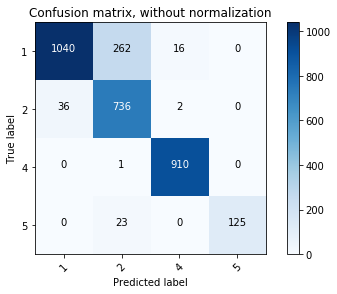

In [39]:
print("F1-measure: ", f1_score(YOH_test_final, YOH_pred, average='weighted'))
print("AUC w.r. to each class: ", AUC(YOH_test_final, YOH_pred))

# Compute and plot confusion matrix
y_test_hard = np.argmax(YOH_test_final, axis=1) #reverse the one-ot encoder procedure
cnf_matrix = confusion_matrix(y_test_hard, y_pred_hard)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,4,5],
                      title='Confusion matrix, without normalization')

In [40]:
def Model2D(input_shape):
    """ 
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns: 
    model -- a Model() instance in Keras
    """
    
    model = Sequential([Conv2D(filters = 18,
                                kernel_size=(5,5),
                                strides=(1,3),
                                padding='same',
                                input_shape = input_shape),
                        BatchNormalization(),
                        Activation('relu'),
                        MaxPooling2D(pool_size=(2,2),
                          strides=2,
                          padding='same'),
                        Flatten(),
                        Dense(64, kernel_regularizer=regularizers.l2(0.01)),
                        Activation('relu'),
                        Dropout(0.4),
                        Dense(classes),
                        Activation('softmax')])
    
    return model

In [44]:
model_bidim = Model2D((1,15,113))
opt2 = Adam(lr=0.01)
model_bidim.compile(optimizer = opt2, loss = "categorical_crossentropy", metrics = ["accuracy"])

# need to reshape in order to fit to the new 2D model
X_train = cube.reshape(cube.shape[0], 1, 15, 113)
X_test = cube_test.reshape(cube_test.shape[0], 1, 15, 113)

model_bidim.fit(x = X_train, y = YOH_train_final, epochs = 10, batch_size = 128, validation_data=(X_test,YOH_test_final))

Train on 9294 samples, validate on 3151 samples
Epoch 1/10
9294/9294 [==============================] - 2s 266us/step - loss: 0.6132 - acc: 0.8202 - val_loss: 0.3943 - val_acc: 0.9029
Epoch 2/10
9294/9294 [==============================] - 2s 201us/step - loss: 0.3339 - acc: 0.8788 - val_loss: 0.3774 - val_acc: 0.8956
Epoch 3/10
9294/9294 [==============================] - 2s 194us/step - loss: 0.3099 - acc: 0.8880 - val_loss: 0.3361 - val_acc: 0.9257
Epoch 4/10
9294/9294 [==============================] - 2s 195us/step - loss: 0.2863 - acc: 0.8989 - val_loss: 0.3343 - val_acc: 0.9251
Epoch 5/10
9294/9294 [==============================] - 2s 195us/step - loss: 0.2828 - acc: 0.9052 - val_loss: 0.3786 - val_acc: 0.9115
Epoch 6/10
9294/9294 [==============================] - 2s 196us/step - loss: 0.2660 - acc: 0.9075 - val_loss: 0.3224 - val_acc: 0.9311
Epoch 7/10
9294/9294 [==============================] - 2s 195us/step - loss: 0.2528 - acc: 0.9164 - val_loss: 0.3601 - val_acc: 0.9130


F1-measure:  0.9272844104296594
AUC w.r. to each class:  {0: 0.9221983663190522, 1: 0.9341501077835719, 2: 0.9960005194448799, 3: 0.9255091755091754}


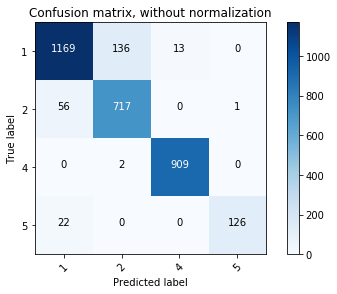

In [45]:
y_pred = model_bidim.predict(X_test)
y_pred_hard = np.argmax(y_pred, axis=1)
YOH_pred = onehot_encoder.fit_transform(y_pred_hard.reshape(-1, 1))

#print("y_pred:\n", y_pred)
#print("\ny_pred_hard:\n", y_pred_hard)
#print("\nYOH_pred:\n", YOH_pred)

print("F1-measure: ", f1_score(YOH_test_final, YOH_pred, average='weighted'))
print("AUC w.r. to each class: ", AUC(YOH_test_final, YOH_pred))

y_test_hard = np.argmax(YOH_test_final, axis=1)
cnf_matrix = confusion_matrix(y_test_hard, y_pred_hard)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,4,5],
                      title='Confusion matrix, without normalization')

# Still Task A, but on a reduced dataset

In [46]:
x1 = scipy.io.loadmat("prep/acc_magni/S1-ADL1", mdict={'reduced_features':'features', 'labels':'labels'})
x2 = scipy.io.loadmat("prep/acc_magni/S1-ADL2", mdict={'reduced_features':'features', 'labels':'labels'})
x3 = scipy.io.loadmat("prep/acc_magni/S1-ADL3", mdict={'reduced_features':'features', 'labels':'labels'})
x4 = scipy.io.loadmat("prep/acc_magni/S1-ADL4", mdict={'reduced_features':'features', 'labels':'labels'})
x5 = scipy.io.loadmat("prep/acc_magni/S1-ADL5", mdict={'reduced_features':'features', 'labels':'labels'})
x6 = scipy.io.loadmat("prep/acc_magni/S1-Drill", mdict={'reduced_features':'features', 'labels':'labels'})

print("Session shapes:\n")
print("ADL1:  ", x1['reduced_features'].shape)
print("ADL2:  ", x2['reduced_features'].shape)
print("ADL3:  ", x3['reduced_features'].shape)
print("ADL4:  ", x4['reduced_features'].shape)
print("ADL5:  ", x5['reduced_features'].shape)
print("Drill: ", x6['reduced_features'].shape)
print("\nTraining set: ADL1 + ADL2 + ADL3 + Drill = ", x1['reduced_features'].shape[0] + x2['reduced_features'].shape[0] + x3['reduced_features'].shape[0] + x6['reduced_features'].shape[0])
print("Test set: ADL4 + ADL5 = ", x4['reduced_features'].shape[0] + x5['reduced_features'].shape[0])

Session shapes:

ADL1:   (37507, 58)
ADL2:   (24510, 58)
ADL3:   (25305, 58)
ADL4:   (24851, 58)
ADL5:   (22440, 58)
Drill:  (52105, 58)

Training set: ADL1 + ADL2 + ADL3 + Drill =  139427
Test set: ADL4 + ADL5 =  47291


In [47]:
# features
X_train = np.concatenate((x1['reduced_features'],x2['reduced_features'],x3['reduced_features'],x6['reduced_features']),axis=0)
X_test = np.concatenate((x4['reduced_features'],x5['reduced_features']),axis=0)

# labels (locomotion activity)
Y_train = np.concatenate((x1['labels'][:,0],x2['labels'][:,0],x3['labels'][:,0],x6['labels'][:,0]),axis=0) # here we take just the first column because we want to fulfill the first task
Y_test = np.concatenate((x4['labels'][:,0],x5['labels'][:,0]))
#Y_test = np.concatenate((x4['labels'][:,0],x5['labels'][:,0]),axis=0)

# Initial decision to overcome the problem of entire missing columns
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

# fatures normalization
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (139427, 58)
X_test shape:  (47291, 58)


In [48]:
label_max = np.max(Y_train)
print("The highest label value is: ", label_max)
onehot_encoder = OneHotEncoder(sparse=False)
YOH_train = onehot_encoder.fit_transform(Y_train.reshape(-1, 1))
YOH_test = onehot_encoder.fit_transform(Y_test.reshape(-1, 1))

print("YOH_train shape: ", YOH_train.shape)
print("YOH_test shape: ", YOH_test.shape)

window_size = 15
stride = int(window_size)
num_features = X_train.shape[1]
samples, classes = YOH_train.shape
print("Number of samples: ", samples, "\nNumber of classes: ", classes)

windows = int(samples // stride) - 1
print("Number of windows: ", windows)

num_features_test = X_test.shape[1]
samples_test, classes_test = YOH_test.shape
print("Number of samples: ", samples_test, "\nNumber of classes: ", classes_test)

windows_test = int(samples_test // stride) - 1
print("Number of windows: ", windows_test)

The highest label value is:  5
YOH_train shape:  (139427, 4)
YOH_test shape:  (47291, 4)
Number of samples:  139427 
Number of classes:  4
Number of windows:  9294
Number of samples:  47291 
Number of classes:  4
Number of windows:  3151


In [49]:
cube = np.zeros([windows, window_size, num_features])
cube.shape

cube_test = np.zeros([windows_test, window_size, num_features])
cube_test.shape

lab_cum = np.zeros([windows])
lab_cum.shape

lab_cum_test = np.zeros([windows_test])
lab_cum_test.shape

for w in range(windows):
    index = int(w * stride)
    cube[w,:,:] = X_train[index:index+window_size, :].reshape((window_size,num_features))
    l = YOH_train[index:index+window_size,:] # shape 50 x 5
    #print(np.sum(l, axis=0),np.argmax(np.sum(l, axis=0)))
    lab_cum[w] = np.argmax(np.sum(l, axis=0))

for w in range(windows_test):
    index = int(w * stride)
    cube_test[w,:,:] = X_test[index:index+window_size, :].reshape((window_size,num_features))
    l = YOH_test[index:index+window_size,:] # shape 50 x 5
    #print(np.sum(l, axis=0),np.argmax(np.sum(l, axis=0)))
    lab_cum_test[w] = np.argmax(np.sum(l, axis=0))

#print('cumulative labels: ', lab_cum.shape, type(lab_cum), "\n", lab_cum)
YOH_train_final = onehot_encoder.fit_transform(lab_cum.reshape(-1, 1))
YOH_test_final = onehot_encoder.fit_transform(lab_cum_test.reshape(-1, 1))

#print(YOH_train_final)
#print(YOH_test_final)

# Test new dataset performances with 1D CNN

In [51]:
model_new1D = Model1D((15,58))

opt = Adam(lr=0.01)
model_new1D.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ["accuracy"])

model_new1D.fit(x = cube, y = YOH_train_final, epochs = 10, batch_size = 64, validation_data=(cube_test,YOH_test_final))

Train on 9294 samples, validate on 3151 samples
Epoch 1/10
9294/9294 [==============================] - 4s 401us/step - loss: 0.6925 - acc: 0.7988 - val_loss: 0.3496 - val_acc: 0.9099
Epoch 2/10
9294/9294 [==============================] - 2s 263us/step - loss: 0.4116 - acc: 0.8519 - val_loss: 0.3546 - val_acc: 0.9105
Epoch 3/10
9294/9294 [==============================] - 2s 262us/step - loss: 0.3631 - acc: 0.8685 - val_loss: 0.3217 - val_acc: 0.9194
Epoch 4/10
9294/9294 [==============================] - 3s 272us/step - loss: 0.3344 - acc: 0.8801 - val_loss: 0.3251 - val_acc: 0.9315
Epoch 5/10
9294/9294 [==============================] - 2s 265us/step - loss: 0.3386 - acc: 0.8848 - val_loss: 0.3111 - val_acc: 0.9286
Epoch 6/10
9294/9294 [==============================] - 3s 286us/step - loss: 0.3236 - acc: 0.8863 - val_loss: 0.3130 - val_acc: 0.9359
Epoch 7/10
9294/9294 [==============================] - 2s 264us/step - loss: 0.3404 - acc: 0.8887 - val_loss: 0.3427 - val_acc: 0.9330


F1-measure:  0.9272844104296594
AUC w.r. to each class:  {0: 0.9221983663190522, 1: 0.9341501077835719, 2: 0.9960005194448799, 3: 0.9255091755091754}


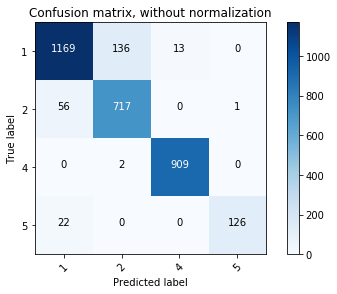

In [52]:
print("F1-measure: ", f1_score(YOH_test_final, YOH_pred, average='weighted'))
print("AUC w.r. to each class: ", AUC(YOH_test_final, YOH_pred))

# Compute and plot confusion matrix
y_test_hard = np.argmax(YOH_test_final, axis=1) #reverse the one-ot encoder procedure
cnf_matrix = confusion_matrix(y_test_hard, y_pred_hard)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,4,5],
                      title='Confusion matrix, without normalization')

# Test new dataset performances with 2D CNN

In [ ]:
model_new2D = Model2D((1,window_size,58))
opt4 = Adam(lr=0.01)
model_new2D.compile(optimizer = opt4, loss = "categorical_crossentropy", metrics = ["accuracy"])

# need to reshape in order to fit to the new 2D model
X_train = cube.reshape(cube.shape[0], 1, window_size, 58)
X_test = cube_test.reshape(cube_test.shape[0], 1, window_size, 58)

Train on 9294 samples, validate on 3151 samples
Epoch 1/10
9294/9294 [==============================] - 1s 132us/step - loss: 0.3203 - acc: 0.8917 - val_loss: 0.3420 - val_acc: 0.9295
Epoch 2/10
9294/9294 [==============================] - 1s 136us/step - loss: 0.3032 - acc: 0.8993 - val_loss: 0.3398 - val_acc: 0.9273
Epoch 3/10
9294/9294 [==============================] - 1s 131us/step - loss: 0.3077 - acc: 0.8982 - val_loss: 0.3318 - val_acc: 0.9289
Epoch 4/10
9294/9294 [==============================] - 1s 141us/step - loss: 0.3055 - acc: 0.8986 - val_loss: 0.3479 - val_acc: 0.9216
Epoch 5/10
9294/9294 [==============================] - 1s 132us/step - loss: 0.2990 - acc: 0.9029 - val_loss: 0.3808 - val_acc: 0.9188
Epoch 6/10
9294/9294 [==============================] - 1s 137us/step - loss: 0.2966 - acc: 0.9019 - val_loss: 0.3818 - val_acc: 0.9194
Epoch 7/10
9294/9294 [==============================] - 1s 135us/step - loss: 0.2840 - acc: 0.9065 - val_loss: 0.3367 - val_acc: 0.9245


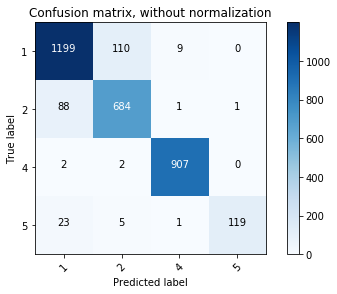

In [55]:
model_new2D.fit(x = X_train, y = YOH_train_final, epochs = 10, batch_size = 128, validation_data=(X_test,YOH_test_final))

y_pred = model_new2D.predict(X_test)
y_pred_hard = np.argmax(y_pred, axis=1)
YOH_pred = onehot_encoder.fit_transform(y_pred_hard.reshape(-1, 1))

#print("y_pred:\n", y_pred)
#print("\ny_pred_hard:\n", y_pred_hard)
#print("\nYOH_pred:\n", YOH_pred)

print("F1-measure: ", f1_score(YOH_test_final, YOH_pred, average='weighted'))
print("AUC w.r. to each class: ", AUC(YOH_test_final, YOH_pred))

y_test_hard = np.argmax(YOH_test_final, axis=1)
cnf_matrix = confusion_matrix(y_test_hard, y_pred_hard)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,4,5],
                      title='Confusion matrix, without normalization')